This notebook contains our experiments for our initial research direction on Sparse Attention. We implemented our matrix multiplication framework to align the distribution of keys and queries and measured the impact on recall and latencies.

# Imports

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
!wget https://dl.fbaipublicfiles.com/billion-scale-ann-benchmarks/18642554/qkv_dumps/prompt{0..19}_layer15_head18_x{q,k,v}.pt

In [ ]:
%mkdir prompts

In [ ]:
%mv prompt* prompts/

mv: cannot move 'prompts' to a subdirectory of itself, 'prompts/prompts'


In [ ]:
import struct
import numpy as np
# Code from Yandex's Vector Search dataset : we do not claim any authorship over these functions.
def read_fbin(filename, start_idx=0, chunk_size=None):
    """ Read *.fbin file that contains float32 vectors
    Args:
        :param filename (str): path to *.fbin file
        :param start_idx (int): start reading vectors from this index
        :param chunk_size (int): number of vectors to read.
                                 If None, read all vectors
    Returns:
        Array of float32 vectors (numpy.ndarray)
    """
    with open(filename, "rb") as f:
        nvecs, dim = np.fromfile(f, count=2, dtype=np.int32)
        nvecs = (nvecs - start_idx) if chunk_size is None else chunk_size
        arr = np.fromfile(f, count=nvecs * dim, dtype=np.float32,
                          offset=start_idx * 4 * dim)
    return arr.reshape(nvecs, dim)


def read_ibin(filename, start_idx=0, chunk_size=None):
    """ Read *.ibin file that contains int32 vectors
    Args:
        :param filename (str): path to *.ibin file
        :param start_idx (int): start reading vectors from this index
        :param chunk_size (int): number of vectors to read.
                                 If None, read all vectors
    Returns:
        Array of int32 vectors (numpy.ndarray)
    """
    with open(filename, "rb") as f:
        nvecs, dim = np.fromfile(f, count=2, dtype=np.int32)
        nvecs = (nvecs - start_idx) if chunk_size is None else chunk_size
        arr = np.fromfile(f, count=nvecs * dim, dtype=np.int32,
                          offset=start_idx * 4 * dim)
    return arr.reshape(nvecs, dim)

In [ ]:
K = [
    torch.load("prompts/prompt" + str(i) + "_layer15_head18_xk.pt").to(torch.float32)[
        128:100128
    ]
    for i in range(0, 20)
]
Q = [
    torch.load("prompts/prompt" + str(i) + "_layer15_head18_xq.pt").to(torch.float32)[
        100128:110128
    ]
    for i in range(0, 20)
]
V = [
    torch.load("prompts/prompt" + str(i) + "_layer15_head18_xv.pt").to(torch.float32)
    for i in range(0, 20)
]
# groundtruth=read_ibin("groundtruth.public.100K.ibin")
yandex_queries = read_fbin("query.public.100K.fbin")
yandex_queries = yandex_queries - np.mean(yandex_queries, axis=0)
yandex_keys = read_fbin("base.1M.fbin")
yandex_keys = yandex_keys - np.mean(yandex_keys, axis=0)

train_keys = torch.cat(K[10:20])
train_keys = train_keys - train_keys.mean(dim=0)
train_keys = train_keys / torch.linalg.norm(train_keys, dim=1).view(-1, 1)
train_queries = torch.cat(Q[10:20])
train_queries = train_queries - train_queries.mean(dim=0)
train_queries = train_queries / torch.linalg.norm(train_queries, dim=1).view(-1, 1)
test_keys = torch.cat(K[0:10])
test_keys = test_keys - test_keys.mean(dim=0)
test_keys = test_keys / torch.linalg.norm(test_keys, dim=1).view(-1, 1)
test_queries = torch.cat(Q[0:10])
test_queries = test_queries - test_queries.mean(dim=0)
test_queries = test_queries / torch.linalg.norm(test_queries, dim=1).view(-1, 1)


# Transforms and Mahanolabis plots

In [ ]:
def squareroot(mat):
    eigenvalues, eigenvectors = torch.linalg.eigh(mat)
    diag = torch.diag(torch.sqrt(eigenvalues))
    return eigenvectors @ diag @ eigenvectors.T


def minus_squareroot(mat):
    eigenvalues, eigenvectors = torch.linalg.eigh(mat)
    diag = torch.diag(1 / torch.sqrt(eigenvalues))
    return eigenvectors @ diag @ eigenvectors.T


In [ ]:
# Verify that A = VDV^T
def stable_transform_keys_queries(keys, queries, eps=1e-8):
    def regularized_covariance(x):
        n = x.shape[0]
        cov = (x.T @ x) / n
        return cov + eps * torch.eye(cov.shape[0], device=cov.device, dtype=cov.dtype)

    def matrix_sqrt(mat):
        # Eigen decomposition with numerical stability
        eigvals, eigvecs = torch.linalg.eigh(mat)
        clipped = torch.clamp(eigvals, min=eps)
        return eigvecs @ torch.diag(clipped.sqrt()) @ eigvecs.T

    def matrix_inv_sqrt(mat):
        eigvals, eigvecs = torch.linalg.eigh(mat)
        clipped = torch.clamp(eigvals, min=eps)
        return eigvecs @ torch.diag(clipped.rsqrt()) @ eigvecs.T

    # Normalization
    queries = queries - queries.mean(dim=0)
    # queries = safe_normalize(queries, dim=1)

    keys = keys - keys.mean(dim=0)

    # Covariances
    S1 = regularized_covariance(queries)
    S2 = regularized_covariance(keys)

    sqrt_S2 = matrix_sqrt(S2)
    inv_sqrt_S2 = matrix_inv_sqrt(S2)

    intermediate = matrix_sqrt(sqrt_S2 @ S1 @ sqrt_S2)
    P = inv_sqrt_S2 @ intermediate @ inv_sqrt_S2

    # Apply transformation
    transformed_keys = keys @ matrix_sqrt(P)
    transformed_queries = queries @ matrix_inv_sqrt(P)

    # Recenter
    # transformed_keys = transformed_keys - transformed_keys.mean(dim=0)
    # transformed_queries = transformed_queries - transformed_queries.mean(dim=0)

    return transformed_keys, transformed_queries


def superficial_transform_keys_queries(keys, queries):
    transformed_queries = queries - queries.mean(dim=0)
    # transformed_queries=queries/torch.linalg.norm(transformed_queries,dim=1).view(-1,1)
    transformed_keys = keys - keys.mean(dim=0)
    # transformed_keys=transformed_keys/torch.mean(torch.linalg.norm(transformed_keys,dim=1))

    return transformed_keys, transformed_queries


def transform_keys_queries_outsideP(keys, queries, keys_outside, queries_outside):
    keys_outside = keys_outside - keys_outside.mean(dim=0)
    queries_outside = queries_outside - queries_outside.mean(dim=0)
    S2 = (1 / keys_outside.shape[0]) * keys_outside.T @ keys_outside
    S1 = (1 / queries_outside.shape[0]) * queries_outside.T @ queries_outside

    sqrtS2 = squareroot(S2)
    msqrtS2 = minus_squareroot(S2)
    intermediate = squareroot(sqrtS2 @ S1 @ sqrtS2)
    P_outside = msqrtS2 @ intermediate @ msqrtS2

    transformed_keys = keys @ squareroot(P_outside)
    transformed_queries = queries @ minus_squareroot(P_outside)

    return transformed_keys, transformed_queries


In [ ]:
def mu_covar(mat):
    mu = torch.mean(mat, dim=0)
    mat = mat-mu
    covar = (1/mat.shape[0])*mat.T@mat
    return mu, covar


def mahanolabis(mat, mu, covar):
    invcovar = torch.linalg.inv(covar)
    vec = mat-mu.view(1, -1)
    prod = (vec@invcovar)*vec
    distances = torch.sum(prod, dim=1)
    return distances


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def plot_eigenvalue_histogram_torch(matrix: torch.Tensor, bins: int = 50, title: str = 'Eigenvalue Histogram'):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square.")

    eigenvalues = torch.linalg.eigvals(matrix)

    eigenvalues_np = eigenvalues.cpu().numpy()

    real_parts = eigenvalues_np.real

    plt.figure(figsize=(8, 5))
    plt.hist(real_parts, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel('Eigenvalue (Real Part)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [ ]:
my_queries = train_queries[::1000].to("cuda")
# my_queries=my_queries-my_queries.mean(dim=0)
# my_queries=my_queries/torch.linalg.norm(my_queries,dim=1).view(-1,1)


In [ ]:
my_keys = train_keys[::1000].to("cuda")
my_keys = my_keys-my_keys.mean(dim=0)
# my_keys=my_keys/torch.linalg.norm(my_keys,dim=1).view(-1,1)


In [ ]:
A = 10000*(my_queries.unsqueeze(0).unsqueeze(-2) *
           my_keys.unsqueeze(1).unsqueeze(-1)).sum(dim=(0, 1))


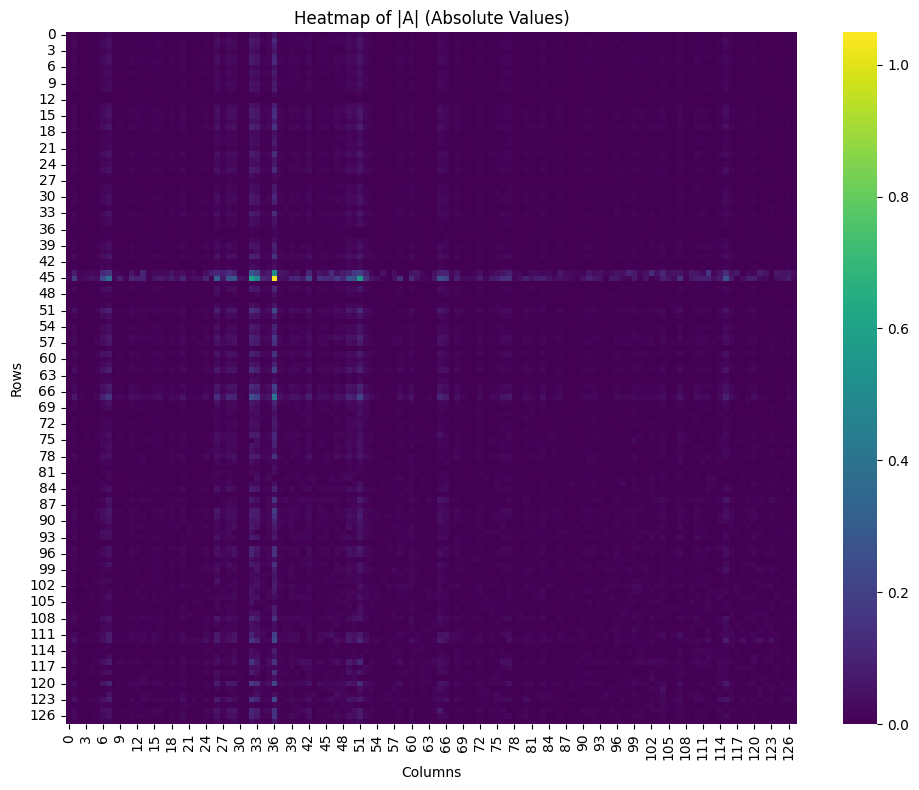

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.abs(A.cpu().numpy()), cmap='viridis', cbar=True)
plt.title("Heatmap of |A| (Absolute Values)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()


In [ ]:
mu_yandex_keys, covar_yandex_keys = mu_covar(torch.tensor(yandex_keys))
mu_yandex_queries, covar_yandex_queries = mu_covar(
    torch.tensor(yandex_queries))
sqrt_covar_yandex_keys = squareroot(covar_yandex_keys)
minus_sqrt_covar_yandex_queries = minus_squareroot(covar_yandex_queries)

keyed_yandex_queries = ((torch.Tensor(
    yandex_queries)@minus_sqrt_covar_yandex_queries)@sqrt_covar_yandex_keys).numpy()


In [ ]:
transformed_yandex_keys, transformed_yandex_queries = stable_transform_keys_queries(
    torch.tensor(yandex_keys), torch.tensor(yandex_queries))


In [ ]:
transformed_train_keys, transformed_train_queries = stable_transform_keys_queries(
    train_keys, train_queries)
transformed_test_keys, transformed_test_queries = stable_transform_keys_queries(
    test_keys, test_queries)
# transformed_keys,transformed_queries=transform_keys_queries_outsideP(keys,queries,keys_outside[::1],queries_outside[::1])

mu_keys, covar_keys = mu_covar(train_keys)
mu_queries, covar_queries = mu_covar(train_queries)
mu_transformed_keys, covar_transformed_keys = mu_covar(transformed_train_keys)

samples = 10000
# for coord in range (0,10):
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 10))
ax1.hist(mahanolabis(
    transformed_train_keys[::10], mu_transformed_keys, covar_transformed_keys).numpy(), bins=200)
ax1.set_title("transformed_keys/transformed_keys")
ax1.set_xlim(25, 500)
# ax3.hist(keys[0:samples,coord:coord+1].squeeze(1).numpy(),bins=200)
# ax3.set_title("original_keys")
# ax3.set_xlim(-3,3)
ax2.hist(mahanolabis(
    transformed_train_queries[::10], mu_transformed_keys, covar_transformed_keys).numpy(), bins=200)
ax2.set_title("transformed_queries/transformed_keys")
ax2.set_xlim(25, 500)
ax3.hist(mahanolabis(train_queries, mu_keys, covar_keys).numpy(), bins=200)
ax3.set_title("queries/keys")
ax3.set_xlim(25, 500)
ax4.hist(mahanolabis(train_keys, mu_keys, covar_keys).numpy(), bins=200)
ax4.set_title("keys/keys")
ax4.set_xlim(25, 500)
ax5.hist(mahanolabis(train_queries, mu_queries, covar_queries).numpy(), bins=200)
ax5.set_title("queries/queries")
ax5.set_xlim(25, 500)
ax6.hist(mahanolabis(train_keys, mu_queries, covar_queries).numpy(), bins=200)
ax6.set_title("keys/queries")
ax6.set_xlim(25, 500)

plt.tight_layout()
plt.show()
# for i in range (0,5):
# print("____________________________________________________________________________")


In [ ]:
mu_keys, covar_keys = mu_covar(torch.tensor(yandex_keys))
mu_queries, covar_queries = mu_covar(torch.tensor(yandex_queries))
mu_transformed_keys, covar_transformed_keys = mu_covar(transformed_yandex_keys)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 10))
ax1.hist(mahanolabis(torch.Tensor(transformed_yandex_keys),
         mu_transformed_keys, covar_transformed_keys).numpy(), bins=200)
ax1.set_title("transformed_keys/transformed_keys")
ax1.set_xlim(25, 500)
# ax3.hist(keys[0:samples,coord:coord+1].squeeze(1).numpy(),bins=200)
# ax3.set_title("original_keys")
# ax3.set_xlim(-3,3)
ax2.hist(mahanolabis(torch.Tensor(transformed_yandex_queries),
         mu_transformed_keys, covar_transformed_keys).numpy(), bins=200)
ax2.set_title("transformed_queries/transformed_keys")
ax2.set_xlim(25, 500)
ax3.hist(mahanolabis(torch.Tensor(yandex_queries),
         mu_keys, covar_keys).numpy(), bins=200)
ax3.set_title("queries/keys")
ax3.set_xlim(25, 500)
ax4.hist(mahanolabis(torch.Tensor(yandex_keys),
         mu_keys, covar_keys).numpy(), bins=200)
ax4.set_title("keys/keys")
ax4.set_xlim(25, 500)
ax5.hist(mahanolabis(torch.Tensor(yandex_queries),
         mu_queries, covar_queries).numpy(), bins=200)
ax5.set_title("queries/queries")
ax5.set_xlim(25, 500)
ax6.hist(mahanolabis(torch.Tensor(yandex_keys),
         mu_queries, covar_queries).numpy(), bins=200)
ax6.set_title("keys/queries")
ax6.set_xlim(25, 500)

plt.tight_layout()
plt.show()


# TSNE and other checks

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


def tsne(data, nbclasses=None):
    data_numpy = data.numpy()

    # Appliquer t-SNE avec sklearn
    tsne = TSNE(n_components=2)  # Réduire en 2 dimensions
    data_2d = tsne.fit_transform(data_numpy)

    colors = np.zeros(data.shape[0])
    if nbclasses is not None:
        colors[0:nbclasses] = 1
    else:
        colors[0:data.shape[0]//2] = 1

    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=colors)
    plt.title("t-SNE Projection")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    plt.scatter(data_2d[0:3000:, 0], data_2d[0:3000, 1])
    plt.title("queries")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()
    plt.scatter(data_2d[3000:6000:, 0], data_2d[3000:6000, 1])
    plt.title("keys")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


tsne(torch.cat([test_queries[2000:5000], test_keys[2000:5000]]))


In [ ]:
tsne(torch.cat([queries[2000:5000],keys[2000:5000]]))

In [ ]:
# import torch
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


def check_gaussian_distribution(tensor, alpha=0.05):
    # Checks if a given (N, D) tensor approximately follows a Gaussian distribution using the Shapiro-Wilk and Anderson-Darling tests
    tensor = tensor.to(torch.float32)
    tensor = tensor.detach().cpu().numpy().flatten()  # Flatten to 1D

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(tensor, bins=50, density=True, alpha=0.6, color='b', label="Data")

    mu, std = np.mean(tensor), np.std(tensor)
    x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), 'r', label="Fitted Gaussian")
    plt.title("Histogram with Gaussian Fit")
    plt.legend()

    plt.subplot(1, 2, 2)
    stats.probplot(tensor, dist="norm", plot=plt)
    plt.title("Q-Q Plot")

    plt.show()

    shapiro_stat, shapiro_p = stats.shapiro(tensor[:5000])

    anderson_result = stats.anderson(tensor, dist='norm')

    print(f"Shapiro-Wilk Test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4g}")
    if shapiro_p < alpha:
        print("Data is not Gaussian")
    else:
        print("Data may be Gaussian")

    print(f"Anderson-Darling Test: A² = {anderson_result.statistic:.4f}")
    for i, (cv, sig_level) in enumerate(zip(anderson_result.critical_values, anderson_result.significance_level)):
        if anderson_result.statistic > cv:
            print(
                f"→ At {sig_level}% significance, reject normality (A² > {cv:.4f})")


In [ ]:
check_gaussian_distribution(keys1[0:5000,0:1])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import numpy as np


def plot_pca_two_sets(tensor1, tensor2, label1="Set 1", label2="Set 2", title="PCA of Two Sets"):

    if isinstance(tensor1, torch.Tensor):
        tensor1 = tensor1.detach().cpu().numpy()
    if isinstance(tensor2, torch.Tensor):
        tensor2 = tensor2.detach().cpu().numpy()

    combined = np.vstack([tensor1, tensor2])
    labels = np.array([label1] * len(tensor1) + [label2] * len(tensor2))

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(combined)

    plt.figure(figsize=(8, 6))
    for label in [label1, label2]:
        idx = labels == label
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.7)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_pca_two_sets(train_keys[::30], train_queries[::10])


# Nearest neighbor search

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np
import time

In [ ]:
def eval_centroids(queries, centroids, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    queries = queries.to(device)
    centroids = centroids.to(device)
    dot_prods = torch.matmul(queries, centroids.T)
    values, labels = torch.topk(dot_prods, 20)
    print(values.shape)
    return torch.mean(values)


In [ ]:
centroids,labels=kmeans(train_keys[::10],1024)
eval_centroids(test_queries,centroids)

In [ ]:
class ExactFaissIndex:
    def __init__(self, keys):
        self.index = faiss.IndexFlatIP(keys.shape[-1])
        self.index.add(keys)

    def search(self, queries, k):
        distances, indices = self.index.search(queries, k)
        return distances, indices


class BaseFaissIndex:
    def __init__(self, keys, exact=True):
        if exact:
            self.exactIndex = ExactFaissIndex(keys)
        else:
            self.exactIndex = None

    def search(self, queries, k):
        distances, indices = self.index.search(queries, k)
        return distances, indices

    def manual_search(self, queries, centroids, keys, labels, k):
        k = centroids.shape[0]
        distances = []
        ivf = {}
        for i in range(0, k, 30):
            c = centroids[i: i + 30].unsqueeze(0)  # (1,k//a,d)
            dps = torch.sum(queries.unsqueeze(1) * c, dim=1)  # (N,k//a)
            distances.append(dps)
        distances = torch.cat(distances, dim=1)
        dps, indices = torch.topk(distances, k)

        return dps, indices

    def recall_time(self, queries, k, with_key=False):
        times = []
        recalls = []
        # print("queries shape",queries.shape)
        first_occ = True
        ips_means = []
        for i, query in enumerate(queries):
            if i % 1000 == 0:
                print(i)
            exact_ips, exact_indices = self.exactIndex.search(
                np.array([query]), k)
            start_time = time.time()
            ips, indices = self.index.search(np.array([query]), k)
            end_time = time.time()
            times.append(end_time - start_time)
            if len(set(np.array(indices.flatten()))) != len(
                np.array(indices.flatten())
            ):
                print("Attention duplicates")
                print(indices)
                print(ips)
            min_ip = np.min(exact_ips)
            recall = np.mean(
                1 * (((1 * (ips >= min_ip) + 1 * (ips < 1e30))) == 2))
            if False:
                print("query shape", query.shape)
                first_occ = False
                print("indices : ", indices)
                print("distances: ", ips)
                print(ips >= min_ip)
                print("recall", recall)
            recalls.append(recall)
            ips_means.append(ips)
        print("ips mean : ", np.mean(ips_means))

        return times, recalls


class HSNWFaissIndex(BaseFaissIndex):
    def __init__(self, keys, M=16, exact=True):
        super().__init__(keys, exact)
        self.index = faiss.IndexHNSWFlat(
            keys.shape[-1], M, faiss.METRIC_INNER_PRODUCT)
        self.index.add(keys)


#
class PQFaissIndex(BaseFaissIndex):
    def __init__(
        self, train_keys, eval_keys, n_centroids=128, code_size=4, exact=True, nprobe=4
    ):
        super().__init__(keys, exact)
        d = keys.shape[-1]
        coarse_quantizer = faiss.IndexFlatIP(d)
        self.index = faiss.IndexIVFPQ(
            coarse_quantizer, d, n_centroids, code_size, 1)
        self.index.nprobe = 1
        self.index.train(train_keys)
        self.index.add(eval_keys)


class IVFFaissIndex(BaseFaissIndex):
    def __init__(
        self,
        train_keys,
        eval_keys,
        n_list=1024,
        exact=True,
        nprobe=20,
        quant="l2",
        custom_centroids=None,
    ):
        super().__init__(eval_keys, exact)
        d = eval_keys.shape[-1]
        if quant == "l2":
            quantizer = faiss.IndexFlatL2(d)
        elif quant == "ip":
            quantizer = faiss.IndexFlatIP(d)
        if custom_centroids is not None:
            assert custom_centroids.shape[0] == n_list
            quantizer.centroids = custom_centroids
        self.index = faiss.IndexIVFFlat(
            quantizer, d, n_list, faiss.METRIC_INNER_PRODUCT
        )

        self.index.nprobe = nprobe
        if custom_centroids is None:
            self.index.train(train_keys)
        else:
            self.index.train([])
        self.index.add(eval_keys)
        # print(self.index.quantizer.xb.shape)
        # print(custom_centroids.shape)
        # print(torch.norm(self.index.quantizer.xb-custom_centroids))


class CustomIndex:
    def __init__(self, centroids, keys, labels):
        self.centroids = centroids
        self.keys = keys
        self.labels = labels
        self.ivf = self.build_ivf()
        self.exactIndex = ExactFaissIndex(keys)

    def build_ivf(self):
        k = self.centroids.shape[0]
        distances = []
        ivf = {}
        print("nkeys : ", self.keys.shape[0])
        for i in range(0, self.keys.shape[0]):
            label = self.labels[i].item()
            key = self.keys[i]
            if label not in ivf:
                ivf[label] = []
            ivf[label].append(key)
        for a in ivf:
            if len(ivf[a]) >= 2:
                print(len(ivf[a]))
            ivf[a] = torch.stack(ivf[a])
            # print(a,ivf[a])
        return ivf

    def manual_search(self, queries, labels, k):
        centroids = self.centroids
        keys = self.keys
        ivf = self.ivf
        nk = centroids.shape[0]
        distances = []
        recalls = []
        for i in range(0, nk, 30):
            c = centroids[i: i + 30].unsqueeze(0)  # (1,k//a,d)
            dps = torch.sum(queries.unsqueeze(1) * c, dim=1)  # (N,k//a)
            distances.append(dps)
        distances = torch.cat(distances, dim=1)
        dps, indices = torch.topk(distances, k)

        for i in range(0, queries.shape[0]):
            query = queries[i]
            idx_centroids = indices[i]
            print(len(ivf.keys()))
            print(ivf.keys())
            print(ivf[0])
            relevant_keys = torch.cat(
                [ivf[j.item()] for j in idx_centroids if j.item() in ivf]
            )
            dps = torch.sum(query.unsqueeze(0) * relevant_keys, dim=1)
            top_dps = np.array(torch.topk(dps, k)[0])
            exact_ips, exact_indices = self.exactIndex.search(
                np.array([query]), k)
            min_ip = np.min(exact_ips)
            print(type(top_dps))
            print(dps.shape)
            print(top_dps.shape)
            recall = np.mean(
                1 * (((1 * (top_dps >= min_ip) + 1 * (top_dps < 1e30))) == 2)
            )
            recalls.append(recall)

        return np.mean(recalls)


In [ ]:
train_queries = train_queries / torch.norm(train_queries,dim=1).view(-1,1)
test_queries = test_queries / torch.norm(test_queries,dim=1).view(-1,1)
train_keys = train_keys / torch.norm(train_keys,dim=1).view(-1,1)
test_keys = test_keys / torch.norm(test_keys,dim=1).view(-1,1)


"""
transformed_train_queries=transformed_train_queries/torch.norm(transformed_train_queries,dim=1).view(-1,1)
transformed_test_queries=transformed_test_queries/torch.norm(transformed_test_queries,dim=1).view(-1,1)
transformed_train_keys=transformed_train_keys/torch.norm(transformed_train_keys,dim=1).view(-1,1)
transformed_test_keys=transformed_test_keys/torch.norm(transformed_test_keys,dim=1).view(-1,1)"""

In [ ]:
mu_train_keys, covar_train_keys = mu_covar(train_keys)
mu_train_queries, covar_train_queries = mu_covar(train_queries)
mu_test_keys, covar_test_keys = mu_covar(test_keys)
mu_test_queries, covar_test_queries = mu_covar(test_queries)
#mu_transformed_keys,covar_transformed_keys=mu_covar(transformed_test_keys)
#mu_transformed_queries,covar_transformed_queries=mu_covar(transformed_test_queries)

In [ ]:
train_keys = train_keys - mu_keys
train_queries = train_queries - mu_queries
test_keys = test_keys - mu_keys
test_queries = test_queries - mu_queries

In [ ]:
# Sanity checks

print(torch.norm(mu_queries-mu_keys))
print(torch.norm(covar_queries-covar_keys))
print(torch.norm(mu_transformed_keys-mu_transformed_queries))
print(torch.norm(covar_transformed_queries-covar_transformed_keys))
print(torch.norm(covar_transformed_keys-covar_queries))


In [ ]:
custom_centroids_mip, labels = kmeans(
    train_keys[::10], 1024, max_iters=20, covar=covar_train_queries)


In [ ]:
normal_centroids, labels = kmeans(train_keys[::10], 1024, max_iters=20)


In [ ]:
train_dataset = train_keys[::10]
custom_centroids_mip, labels = kmeans(
    train_dataset, 1024, max_iters=20, covar=covar_train_queries)


In [ ]:
custom_index=CustomIndex(custom_centroids_mip.cpu().detach(),train_dataset,labels)

In [ ]:
custom_index.manual_search(train_queries[::100],labels,10)

In [ ]:
# Basic KMeans Sparse Attention

index = IVFFaissIndex(train_keys[::10], train_keys[::10])
times, recalls = index.recall_time(train_queries[::100], 10)
print("Recall : ", np.mean(recalls), ", Times : ", np.mean(times))
print("nlist:", faiss.cvar.indexIVF_stats.nlist)  # number of probed clusters
# number of distance computations
print("ndist:", faiss.cvar.indexIVF_stats.ndis)
faiss.cvar.indexIVF_stats.reset()


In [ ]:
# Sparse Attention using our distribution alignment framework

index = IVFFaissIndex(
    transformed_train_keys[::100], transformed_test_keys[::10])
times, recalls = index.recall_time(test_queries[::500], 10)
print("Recall : ", np.mean(recalls), ", Times : ", np.mean(times))
print("nlist:", faiss.cvar.indexIVF_stats.nlist)  # number of probed clusters
# number of distance computations
print("ndist:", faiss.cvar.indexIVF_stats.ndis)
faiss.cvar.indexIVF_stats.reset()


In [ ]:
index = IVFFaissIndex(train_keys[::10], test_keys[::10], quant="l2")
times, recalls = index.recall_time(test_queries[::100], 10)
print("Recall : ", np.mean(recalls), ", Times : ", np.mean(times))
print("nlist:", faiss.cvar.indexIVF_stats.nlist)  # number of probed clusters
# number of distance computations
print("ndist:", faiss.cvar.indexIVF_stats.ndis)
faiss.cvar.indexIVF_stats.reset()


In [ ]:
mutk, covartk = mu_covar(transformed_yandex_keys)


In [ ]:
distances_queries = mahanolabis(transformed_yandex_queries, mutk, covartk)
distances_keys = mahanolabis(transformed_yandex_keys, mutk, covartk)


In [ ]:
index = IVFFaissIndex(transformed_yandex_keys)
timesq, recallsq = index.recall_time(transformed_yandex_queries, 10)
print("Recall : ", np.mean(recallsq), ", Times : ", np.mean(timesq))
print("nlist:", faiss.cvar.indexIVF_stats.nlist)  # number of probed clusters
# number of distance computations
print("ndis:", faiss.cvar.indexIVF_stats.ndis)


In [ ]:
index = IVFFaissIndex(transformed_yandex_keys)
timesk, recallsk = index.recall_time(transformed_yandex_keys, 10)
print("Recall : ", np.mean(recallsk), ", Times : ", np.mean(timesk))
print("nlist:", faiss.cvar.indexIVF_stats.nlist)  # number of probed clusters
# number of distance computations
print("ndis:", faiss.cvar.indexIVF_stats.ndis)


In [ ]:
ood_recalls = [recallsk[i]
               for i in range(0, len(distances)) if (distances[i] > 150)]


In [ ]:
def recall_plot(train_keys, eval_keys, queries, nprobemin=10, nprobemax=30, pas=2, top_k=10):
    # Recall / Scan-percentage plots

    Scan_percentage = []
    Recall = []
    for nprobe in range(nprobemin, nprobemax, pas):
        index = IVFFaissIndex(train_keys, eval_keys, nprobe=nprobe)
        times, recalls = index.recall_time(queries, top_k)
        scanned = faiss.cvar.indexIVF_stats.ndis / \
            (eval_keys.shape[0]*queries.shape[0])
        faiss.cvar.indexIVF_stats.reset()
        Scan_percentage.append(scanned)
        Recall.append(np.mean(recalls))
    return Scan_percentage, Recall


In [ ]:
X_notransform, Y_notransform = recall_plot(
    train_keys[::100], test_keys[::10], test_queries[::20], nprobemin=10, nprobemax=30, pas=2)


In [ ]:
X_transform, Y_transform = recall_plot(
    transformed_train_keys[::100], transformed_test_keys[::20], transformed_test_queries[::20], nprobemin=10, nprobemax=30, pas=2)


## Experiments on the Yandex Vector Search Dataset

In [ ]:
suptransformed_yandex_keys, suptransformed_yandex_queries = superficial_transform_keys_queries(
    torch.tensor(yandex_keys), torch.tensor(yandex_queries))


In [ ]:
X_suptransform, Y_suptransform = recall_plot(
    suptransformed_yandex_keys[::100], suptransformed_yandex_queries[::10], nprobemin=10, nprobemax=30, pas=2)


In [ ]:
X_id, Y_id = recall_plot(transformed_train_keys[::100], transformed_test_keys[::10],
                         transformed_test_keys[1:][::50], nprobemin=10, nprobemax=30, pas=2)


In [ ]:
def plot_eigvals(tensor, label=""):
    cumSum = np.cumsum(np.sort(torch.linalg.eigvals(tensor).numpy()))
    plt.plot(cumSum/cumSum[-1], label=label)


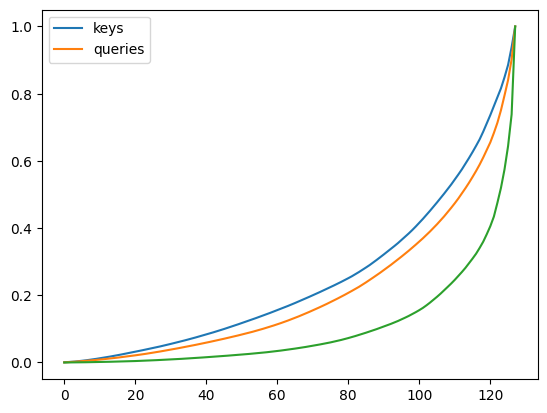

In [ ]:
plot_eigvals(keys.T@keys,label="keys")
plot_eigvals(queries.T@queries,label="queries")
plt.legend()